# Import important libraries

In [1]:
import PIL  #(Pillow)
from PIL import Image
import numpy as np
from numpy import asarray
import pandas as pd
import os
import cv2
import imageio
import dlib
import seaborn as sns
import json
import random
import torchvision
import torchvision.transforms.functional as FT
from torchvision import transforms as transforms
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn
from torch import tensor
from torch.utils import data
from torch.utils.data import Dataset
import torch.backends.cudnn as cudnn
import math
from math import exp, log10, sqrt
import matplotlib.pyplot as plt
import time
import skimage 
from skimage.transform import resize
from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.transform import resize,rescale
from urllib.request import urlopen


# Data Visualization 

In [2]:
from skimage.io import imread, imsave
from skimage.transform import resize

num_in_row = 6
num_in_col = 3
path = '/kaggle/input/tudumm/archive/train/images_hr'
full_img = None
line_img = None
files = [os.path.join(path, file) for file in np.random.choice(os.listdir(path), size=num_in_row * num_in_col)]
for i, file in enumerate(files):
    img = resize(imread(file), (256, 256))
    if line_img is None:
        line_img = img
        continue
        
    if (i) % (num_in_row) != 0:
        line_img = np.concatenate((line_img, img), axis=1)
    elif full_img is None:
        full_img = line_img.copy()
        line_img = img
    else:
        full_img = np.concatenate((full_img, line_img), axis=0)
        line_img = img
full_img = np.concatenate((full_img, line_img), axis=0)

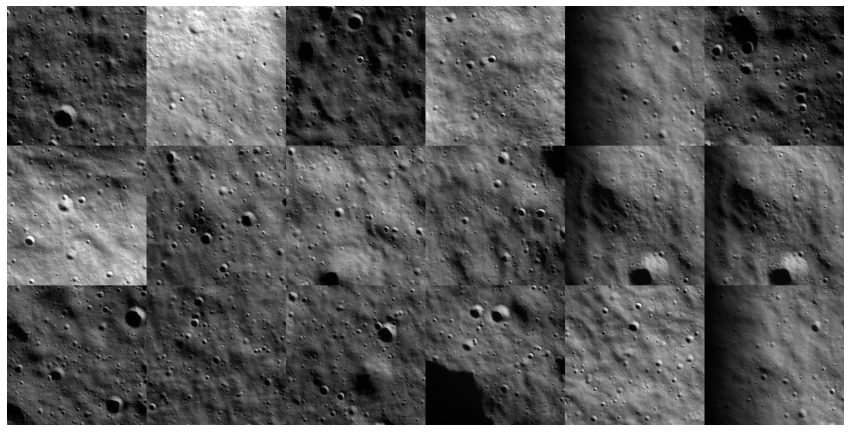

In [3]:
plt.figure(figsize=(15,15))
plt.imshow(full_img)
plt.axis('off')

imsave('images.png', full_img)

# Constants

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Some constants
rgb_weights = torch.FloatTensor([65.481, 128.553, 24.966]).to(device)


def convert_image(img, source, target):
    """
    Convert an image from a source format to a target format.
    :param img: image
    :param source: source format, one of 'pil' (PIL image), '[0, 1]' or '[-1, 1]' (pixel value ranges)
    :param target: target format, one of 'pil' (PIL image), '[0, 255]', '[0, 1]', '[-1, 1]' (pixel value ranges),
                   'y-channel' (luminance channel Y in the YCbCr color format, used to calculate PSNR and SSIM)
    :return: converted image
    """
    assert source in {'pil', '[0, 1]', '[-1, 1]'}, "Cannot convert from source format %s!" % source
    assert target in {'pil', '[0, 255]', '[0, 1]', '[-1, 1]',
                      'y-channel'}, "Cannot convert to target format %s!" % target

    # Convert from source to [0, 1]
    if source == 'pil':
        img = FT.to_tensor(img)

    elif source == '[0, 1]':
        pass  # already in [0, 1]

    elif source == '[-1, 1]':
        img = (img + 1.) / 2.

    # Convert from [0, 1] to target
    if target == 'pil':
        img = FT.to_pil_image(img)

    elif target == '[0, 255]':
        img = 255. * img

    elif target == '[0, 1]':
        pass  # already in [0, 1]

    elif target == '[-1, 1]':
        img = 2. * img - 1.

    elif target == 'y-channel':
        img = torch.matmul(255. * img.permute(0, 2, 3, 1)[:, 4:-4, 4:-4, :], rgb_weights) / 255. + 16.

    return img


class ImageTransforms(object):
    """
    Image transformation pipeline.
    """

    def __init__(self, split, crop_size, scaling_factor, lr_img_type, hr_img_type):
        """
        :param split: one of 'train' or 'test'
        :param crop_size: crop size of HR images
        :param scaling_factor: LR images will be downsampled from the HR images by this factor
        :param lr_img_type: the target format for the LR image; see convert_image() above for available formats
        :param hr_img_type: the target format for the HR image; see convert_image() above for available formats
        """
        self.split = split.lower()
        self.crop_size = crop_size
        self.scaling_factor = scaling_factor
        self.lr_img_type = lr_img_type
        self.hr_img_type = hr_img_type

        assert self.split in {'train', 'valid'}

    def __call__(self, img):
        """
        :param img: a PIL source image from which the HR image will be cropped, and then downsampled to create the LR image
        :return: LR and HR images in the specified format
        """

        # Crop
        if self.split == 'train':
            # Take a random fixed-size crop of the image, which will serve as the high-resolution (HR) image
            left = random.randint(1, img.width - self.crop_size)
            top = random.randint(1, img.height - self.crop_size)
            right = left + self.crop_size
            bottom = top + self.crop_size
            hr_img = img.crop((left, top, right, bottom))
        elif self.split == 'valid':
            # Take a random fixed-size crop of the image, which will serve as the high-resolution (HR) image
            left = random.randint(1, img.width - self.crop_size)
            top = random.randint(1, img.height - self.crop_size)
            right = left + self.crop_size
            bottom = top + self.crop_size
            hr_img = img.crop((left, top, right, bottom))
        else:
            # Take the largest possible center-crop of it such that its dimensions are perfectly divisible by the scaling factor
            x_remainder = img.width % self.scaling_factor
            y_remainder = img.height % self.scaling_factor
            left = x_remainder // 2
            top = y_remainder // 2
            right = left + (img.width - x_remainder)
            bottom = top + (img.height - y_remainder)
            hr_img = img.crop((left, top, right, bottom))

        lr_img = hr_img.resize((int(hr_img.width / self.scaling_factor), int(hr_img.height / self.scaling_factor)),
                               Image.BICUBIC)

        assert hr_img.width == lr_img.width * self.scaling_factor and hr_img.height == lr_img.height * self.scaling_factor

        lr_img = convert_image(lr_img, source='pil', target=self.lr_img_type)
        hr_img = convert_image(hr_img, source='pil', target=self.hr_img_type)

        return lr_img, hr_img


class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)


def save_checkpoint(state, filename):
    """
    Save model checkpoint.
    :param state: checkpoint contents
    """
    torch.save(state, filename)


def adjust_learning_rate(optimizer, shrink_factor):
    """
    Shrinks learning rate by a specified factor.
    :param optimizer: optimizer whose learning rate must be shrunk.
    :param shrink_factor: factor in interval (0, 1) to multiply learning rate with.
    """

    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))# This Python 3 environment comes with many helpful analytics libraries installed

import numpy as np 
import pandas as pd

# Now we have to build the class Dataset

In [5]:

class SRDataset(Dataset):
    """
    A PyTorch Dataset to be used by a PyTorch DataLoader.
    """

    def __init__(self, data_folder, split, crop_size, scaling_factor, lr_img_type, hr_img_type):
        """
        :param data_folder: data with images
        :param split: one of 'train' or 'valid'
        :param crop_size: crop size of target HR images
        :param scaling_factor: the input LR images will be downsampled from the target HR images by this factor; the scaling done in the super-resolution
        :param lr_img_type: the format for the LR image supplied to the model; see convert_image() in utils.py for available formats
        :param hr_img_type: the format for the HR image supplied to the model; see convert_image() in utils.py for available formats
        """

        self.data_folder = data_folder
        self.split = split.lower()
        self.crop_size = int(crop_size)
        self.scaling_factor = int(scaling_factor)
        self.lr_img_type = lr_img_type
        self.hr_img_type = hr_img_type


        assert lr_img_type in {'[0, 255]', '[0, 1]', '[-1, 1]'}
        assert hr_img_type in {'[0, 255]', '[0, 1]', '[-1, 1]'}

        if self.split == 'train':
            assert self.crop_size % self.scaling_factor == 0, "Crop dimensions are not perfectly divisible by scaling factor! This will lead to a mismatch in the dimensions of the original HR patches and their super-resolved (SR) versions!"

#         Read list of image-paths
        if self.split == 'train':
            path = os.path.join(data_folder, 'train','images_hr')
        else:
            path = os.path.join(data_folder, 'test','images_hr')
#         path = self.data_folder
            
        self.images = [os.path.join(path, file) for file in os.listdir(path)]
        
        # Select the correct set of transforms
        self.transform = ImageTransforms(split=self.split,
                                         crop_size=self.crop_size,
                                         scaling_factor=self.scaling_factor,
                                         lr_img_type=self.lr_img_type,
                                         hr_img_type=self.hr_img_type)

    def __getitem__(self, i):
        """
        This method is required to be defined for use in the PyTorch DataLoader.
        :param i: index to retrieve
        :return: the 'i'th pair LR and HR images to be fed into the model
        """
        # Read image
        img = Image.open(self.images[i], mode='r')
        img = img.convert('RGB')
        if img.width <= 96 or img.height <= 96:
            print(self.images[i], img.width, img.height)
        lr_img, hr_img = self.transform(img)

        return lr_img, hr_img

    def __len__(self):
        """
        This method is required to be defined for use in the PyTorch DataLoader.
        :return: size of this data (in number of images)
        """
        return len(self.images)

# Convolutional and training model

In [6]:

class ConvolutionalBlock(nn.Module):
    """
    A convolutional block, comprising convolutional, BN, activation layers.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, batch_norm=False, activation=None):
        """
        :param in_channels: number of input channels
        :param out_channels: number of output channe;s
        :param kernel_size: kernel size
        :param stride: stride
        :param batch_norm: include a BN layer?
        :param activation: Type of activation; None if none
        """
        super(ConvolutionalBlock, self).__init__()

        if activation is not None:
            activation = activation.lower()
            assert activation in {'prelu', 'leakyrelu', 'tanh', 'sigmoid'}

        # A container that will hold the layers in this convolutional block
        layers = list()

        # A convolutional layer
        layers.append(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                      padding=kernel_size // 2))

        # A batch normalization (BN) layer, if wanted
        if batch_norm is True:
            layers.append(nn.BatchNorm2d(num_features=out_channels))

        # An activation layer, if wanted
        if activation == 'prelu':
            layers.append(nn.PReLU())
        elif activation == 'leakyrelu':
            layers.append(nn.LeakyReLU(0.2))
        elif activation == 'tanh':
            layers.append(nn.Tanh())
        elif activation == 'sigmoid':
            layers.append(nn.Sigmoid())

        # Put together the convolutional block as a sequence of the layers in this container
        self.conv_block = nn.Sequential(*layers)

    def forward(self, input):
        """
        Forward propagation.
        :param input: input images, a tensor of size (N, in_channels, w, h)
        :return: output images, a tensor of size (N, out_channels, w, h)
        """
        output = self.conv_block(input)  # (N, out_channels, w, h)

        return output


class SubPixelConvolutionalBlock(nn.Module):
    """
    A subpixel convolutional block, comprising convolutional, pixel-shuffle, and PReLU activation layers.
    """

    def __init__(self, kernel_size=3, n_channels=64, scaling_factor=2):
        """
        :param kernel_size: kernel size of the convolution
        :param n_channels: number of input and output channels
        :param scaling_factor: factor to scale input images by (along both dimensions)
        """
        super(SubPixelConvolutionalBlock, self).__init__()

        # A convolutional layer that increases the number of channels by scaling factor^2, followed by pixel shuffle and PReLU
        self.conv = nn.Conv2d(in_channels=n_channels, out_channels=n_channels * (scaling_factor ** 2),
                              kernel_size=kernel_size, padding=kernel_size // 2)
        # These additional channels are shuffled to form additional pixels, upscaling each dimension by the scaling factor
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=scaling_factor)
        self.prelu = nn.PReLU()

    def forward(self, input):
        """
        Forward propagation.
        :param input: input images, a tensor of size (N, n_channels, w, h)
        :return: scaled output images, a tensor of size (N, n_channels, w * scaling factor, h * scaling factor)
        """
        output = self.conv(input)
        output = self.pixel_shuffle(output)
        output = self.prelu(output) 

        return output




# Class SRResNet

In [7]:
class ResidualBlock(nn.Module):
    """
    A residual block, comprising two convolutional blocks with a residual connection across them.
    """

    def __init__(self, kernel_size=3, n_channels=64):
        """
        :param kernel_size: kernel size
        :param n_channels: number of input and output channels (same because the input must be added to the output)
        """
        super(ResidualBlock, self).__init__()

        # The first convolutional block
        self.conv_block1 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,
                                              batch_norm=True, activation='PReLu')

        # The second convolutional block
        self.conv_block2 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,
                                              batch_norm=True, activation=None)

    def forward(self, input):
        """
        Forward propagation.
        :param input: input images, a tensor of size (N, n_channels, w, h)
        :return: output images, a tensor of size (N, n_channels, w, h)
        """
        residual = input  # (N, n_channels, w, h)
        output = self.conv_block1(input)  # (N, n_channels, w, h)
        output = self.conv_block2(output)  # (N, n_channels, w, h)
        output = output + residual  # (N, n_channels, w, h)

        return output


class SRResNet(nn.Module):
    """
    The SRResNet, as defined in the paper.
    """

    def __init__(self, large_kernel_size=9, small_kernel_size=3, n_channels=64, n_blocks=16, scaling_factor=4):
        """
        :param large_kernel_size: kernel size of the first and last convolutions which transform the inputs and outputs
        :param small_kernel_size: kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
        :param n_channels: number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
        :param n_blocks: number of residual blocks
        :param scaling_factor: factor to scale input images by (along both dimensions) in the subpixel convolutional block
        """
        super(SRResNet, self).__init__()

        # Scaling factor must be 2, 4, or 8
        scaling_factor = int(scaling_factor)
        assert scaling_factor in {2, 4, 8}, "The scaling factor must be 2, 4, or 8!"

        # The first convolutional block
        self.conv_block1 = ConvolutionalBlock(in_channels=3, out_channels=n_channels, kernel_size=large_kernel_size,
                                              batch_norm=False, activation='PReLu')

        # A sequence of n_blocks residual blocks, each containing a skip-connection across the block
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(kernel_size=small_kernel_size, n_channels=n_channels) for i in range(n_blocks)])

        # Another convolutional block
        self.conv_block2 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels,
                                              kernel_size=small_kernel_size,
                                              batch_norm=True, activation=None)

        # Upscaling is done by sub-pixel convolution, with each such block upscaling by a factor of 2
        n_subpixel_convolution_blocks = int(math.log2(scaling_factor))
        self.subpixel_convolutional_blocks = nn.Sequential(
            *[SubPixelConvolutionalBlock(kernel_size=small_kernel_size, n_channels=n_channels, scaling_factor=2) for i
              in range(n_subpixel_convolution_blocks)])

        # The last convolutional block
        self.conv_block3 = ConvolutionalBlock(
            in_channels=n_channels, 
            out_channels=3, 
            kernel_size=large_kernel_size,
            batch_norm=False, 
            activation='tanh')

    def forward(self, lr_imgs):
        """
        Forward prop.
        :param lr_imgs: low-resolution input images, a tensor of size (N, 3, w, h)
        :return: super-resolution output images, a tensor of size (N, 3, w * scaling factor, h * scaling factor)
        """
        output = self.conv_block1(lr_imgs)  # (N, 3, w, h)
        residual = output  # (N, n_channels, w, h)
        output = self.residual_blocks(output)  # (N, n_channels, w, h)
        output = self.conv_block2(output)  # (N, n_channels, w, h)
        output = output + residual  # (N, n_channels, w, h)
        output = self.subpixel_convolutional_blocks(output)  # (N, n_channels, w * scaling factor, h * scaling factor)
        sr_imgs = self.conv_block3(output)  # (N, 3, w * scaling factor, h * scaling factor)

        return sr_imgs

In [8]:
from tqdm import tqdm

# Execution

In [18]:
# Data parameters
data_folder = '/kaggle/input/tudumm/archive'  # folder with JSON data files
crop_size = 96  # crop size of target HR images
scaling_factor = 8  # the scaling factor for the generator; the input LR images will be downsampled from the target HR images by this factor

# Model parameters
large_kernel_size = 9  # kernel size of the first and last convolutions which transform the inputs and outputs
small_kernel_size = 3  # kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
n_channels = 128  # number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
n_blocks = 32  # number of residual blocks

# Learning parameters

if os.path.exists('./checkpoint_srresnet.pth.tar'):
    print('Read from ./checkpoint_srresnet.pth.tar')
    checkpoint = './checkpoint_srresnet.pth.tar' 
elif os.path.exists('../input/weightsresnet/checkpoint_srresnet.pth.tar'):
    print('Read from ../input/weightsresnet/checkpoint_srresnet.pth.tar')
    checkpoint = '../input/weightsresnet/checkpoint_srresnet.pth.tar'     
else:
    checkpoint = None  # path to model checkpoint, None if none
    print('Ther are no any Weights!')
# checkpoint = None
    
batch_size = 4# batch size

start_epoch = 0  # start at this epoch
epochs = 100  # number of training iterations

workers = 4  # number of workers for loading data in the DataLoader
print_freq = 500  # print training status once every __ batches
lr = 1e-4  # learning rate
grad_clip = None  # clip if gradients are exploding

cudnn.benchmark = True

loss_curve_train = []
loss_curve_valid = []


def main():
    """
    Training.
    """
    global start_epoch, epoch, checkpoint
    #checkpoint = "./checkpoint_srresnet.pth.tar" 
    

    # Initialize model or load checkpoint
    if checkpoint is None:
        model = SRResNet(large_kernel_size=large_kernel_size, small_kernel_size=small_kernel_size,
                         n_channels=n_channels, n_blocks=n_blocks, scaling_factor=scaling_factor)
        # Initialize the optimizer
        optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()),
                                     lr=lr)

    else:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch'] + 1
        model = checkpoint['model']
        optimizer = checkpoint['optimizer']

    # Move to default device
    model = model.to(device)
    criterion = nn.L1Loss().to(device)

    # Custom dataloaders
    train_dataset = SRDataset(data_folder,
                              split='train',
                              crop_size=crop_size,
                              scaling_factor=scaling_factor,
                              lr_img_type='[-1, 1]',
                              hr_img_type='[-1, 1]')
    
    valid_dataset = SRDataset(data_folder,
                              split='valid',
                              crop_size=crop_size,
                              scaling_factor=scaling_factor,
                              lr_img_type='[-1, 1]',
                              hr_img_type='[-1, 1]')
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=batch_size,
        shuffle=True, 
        num_workers=workers,
        pin_memory=True)
    
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=workers,
        pin_memory=True)

    # Epochs
    for epoch in range(start_epoch, epochs):
        # One epoch's training
        train_losses = train(train_loader=train_loader,
              model=model,
              criterion=criterion,
              optimizer=optimizer)
        
        valid_losses = valid(valid_loader=valid_loader,
              model=model,
              criterion=criterion)
        
        print('Epoch: [{0}] ---- '
              'Train Average Loss: {train_loss.avg:.4f} ---- '
              'Valid Average Loss: {valid_loss.avg:.4f}'
              .format(epoch,
                      train_loss=train_losses,
                      valid_loss=valid_losses))
        
        loss_curve_train.append(train_losses.avg)
        loss_curve_valid.append(valid_losses.avg)

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer
        },
            'checkpoint_srresnet.pth.tar'
        )


def train(train_loader, model, criterion, optimizer):
    """
    One epoch's training.
    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: content loss function (Mean Squared-Error loss)
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables batch normalization

    data_time = AverageMeter()
    losses = AverageMeter()

    for i, (lr_imgs, hr_imgs) in tqdm(enumerate(train_loader)):

        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)

        sr_imgs = model(lr_imgs)

        loss = criterion(sr_imgs, hr_imgs)

        optimizer.zero_grad()
        loss.backward()

        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        optimizer.step()

        # Keep track of loss
        losses.update(loss.item(), lr_imgs.size(0))

    del lr_imgs, hr_imgs, sr_imgs  # free some memory since their histories may be stored
    return losses
    
    
def valid(valid_loader, model, criterion):
    """
    One epoch's training.
    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: content loss function (Mean Squared-Error loss)
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    model.eval() 

    data_time = AverageMeter()
    losses = AverageMeter()

    for i, (lr_imgs, hr_imgs) in tqdm(enumerate(valid_loader)):

        # Move to default device
        lr_imgs = lr_imgs.to(device)  # (batch_size (N), 3, 24, 24), imagenet-normed
        hr_imgs = hr_imgs.to(device)  # (batch_size (N), 3, 96, 96), in [-1, 1]

        # Forward prop.
        sr_imgs = model(lr_imgs)  # (N, 3, 96, 96), in [-1, 1]

        # Loss
        loss = criterion(sr_imgs, hr_imgs)  # scalar

        # Keep track of loss
        losses.update(loss.item(), lr_imgs.size(0))


    del lr_imgs, hr_imgs, sr_imgs  # free some memory since their histories may be stored
    return losses

if __name__ == '__main__':
    main()

Read from ./checkpoint_srresnet.pth.tar


24it [00:04,  5.85it/s]
8it [00:01,  5.12it/s]


Epoch: [10] ---- Train Average Loss: 0.0808 ---- Valid Average Loss: 0.0893


24it [00:04,  5.93it/s]
8it [00:01,  6.87it/s]


Epoch: [11] ---- Train Average Loss: 0.0835 ---- Valid Average Loss: 0.0818


24it [00:03,  6.25it/s]
8it [00:01,  7.16it/s]


Epoch: [12] ---- Train Average Loss: 0.0911 ---- Valid Average Loss: 0.0896


24it [00:04,  5.76it/s]
8it [00:01,  7.22it/s]


Epoch: [13] ---- Train Average Loss: 0.0749 ---- Valid Average Loss: 0.0725


24it [00:03,  6.27it/s]
8it [00:01,  7.17it/s]


Epoch: [14] ---- Train Average Loss: 0.0695 ---- Valid Average Loss: 0.0707


24it [00:04,  5.88it/s]
8it [00:01,  7.03it/s]


Epoch: [15] ---- Train Average Loss: 0.0772 ---- Valid Average Loss: 0.0792


24it [00:04,  5.40it/s]
8it [00:01,  6.98it/s]


Epoch: [16] ---- Train Average Loss: 0.0734 ---- Valid Average Loss: 0.0635


24it [00:03,  6.28it/s]
8it [00:01,  7.12it/s]


Epoch: [17] ---- Train Average Loss: 0.0731 ---- Valid Average Loss: 0.0832


24it [00:03,  6.22it/s]
8it [00:01,  6.17it/s]


Epoch: [18] ---- Train Average Loss: 0.0753 ---- Valid Average Loss: 0.0740


24it [00:03,  6.34it/s]
8it [00:01,  7.12it/s]


Epoch: [19] ---- Train Average Loss: 0.0721 ---- Valid Average Loss: 0.0885


24it [00:03,  6.27it/s]
8it [00:01,  5.78it/s]


Epoch: [20] ---- Train Average Loss: 0.0712 ---- Valid Average Loss: 0.0733


24it [00:04,  5.46it/s]
8it [00:01,  7.20it/s]


Epoch: [21] ---- Train Average Loss: 0.0753 ---- Valid Average Loss: 0.0876


24it [00:04,  5.84it/s]
8it [00:01,  7.03it/s]


Epoch: [22] ---- Train Average Loss: 0.0693 ---- Valid Average Loss: 0.0692


24it [00:03,  6.38it/s]
8it [00:01,  6.72it/s]


Epoch: [23] ---- Train Average Loss: 0.0641 ---- Valid Average Loss: 0.0675


24it [00:04,  5.88it/s]
8it [00:01,  7.22it/s]


Epoch: [24] ---- Train Average Loss: 0.0642 ---- Valid Average Loss: 0.0715


24it [00:03,  6.22it/s]
8it [00:01,  7.30it/s]


Epoch: [25] ---- Train Average Loss: 0.0676 ---- Valid Average Loss: 0.0702


24it [00:04,  5.92it/s]
8it [00:01,  4.66it/s]


Epoch: [26] ---- Train Average Loss: 0.0659 ---- Valid Average Loss: 0.0619


24it [00:03,  6.28it/s]
8it [00:01,  7.05it/s]


Epoch: [27] ---- Train Average Loss: 0.0689 ---- Valid Average Loss: 0.0646


24it [00:04,  5.91it/s]
8it [00:01,  6.84it/s]


Epoch: [28] ---- Train Average Loss: 0.0619 ---- Valid Average Loss: 0.0593


24it [00:03,  6.24it/s]
8it [00:01,  7.09it/s]


Epoch: [29] ---- Train Average Loss: 0.0626 ---- Valid Average Loss: 0.0604


24it [00:04,  5.83it/s]
8it [00:01,  7.37it/s]


Epoch: [30] ---- Train Average Loss: 0.0606 ---- Valid Average Loss: 0.0582


24it [00:03,  6.32it/s]
8it [00:01,  6.79it/s]


Epoch: [31] ---- Train Average Loss: 0.0609 ---- Valid Average Loss: 0.0657


24it [00:04,  5.32it/s]
8it [00:01,  5.91it/s]


Epoch: [32] ---- Train Average Loss: 0.0684 ---- Valid Average Loss: 0.0984


24it [00:03,  6.17it/s]
8it [00:01,  6.19it/s]


Epoch: [33] ---- Train Average Loss: 0.0712 ---- Valid Average Loss: 0.0672


24it [00:03,  6.15it/s]
8it [00:01,  7.09it/s]


Epoch: [34] ---- Train Average Loss: 0.0579 ---- Valid Average Loss: 0.0602


24it [00:04,  5.83it/s]
8it [00:01,  6.18it/s]


Epoch: [35] ---- Train Average Loss: 0.0582 ---- Valid Average Loss: 0.0602


24it [00:03,  6.34it/s]
8it [00:01,  7.22it/s]


Epoch: [36] ---- Train Average Loss: 0.0596 ---- Valid Average Loss: 0.0626


24it [00:04,  5.07it/s]
8it [00:01,  6.79it/s]


Epoch: [37] ---- Train Average Loss: 0.0596 ---- Valid Average Loss: 0.0642


24it [00:03,  6.37it/s]
8it [00:01,  6.76it/s]


Epoch: [38] ---- Train Average Loss: 0.0589 ---- Valid Average Loss: 0.0665


24it [00:04,  5.87it/s]
8it [00:01,  7.10it/s]


Epoch: [39] ---- Train Average Loss: 0.0578 ---- Valid Average Loss: 0.0632


24it [00:03,  6.24it/s]
8it [00:01,  7.09it/s]


Epoch: [40] ---- Train Average Loss: 0.0578 ---- Valid Average Loss: 0.0594


24it [00:04,  5.50it/s]
8it [00:01,  7.27it/s]


Epoch: [41] ---- Train Average Loss: 0.0591 ---- Valid Average Loss: 0.0567


24it [00:04,  6.00it/s]
8it [00:01,  4.54it/s]


Epoch: [42] ---- Train Average Loss: 0.0591 ---- Valid Average Loss: 0.0595


24it [00:03,  6.33it/s]
8it [00:01,  6.71it/s]


Epoch: [43] ---- Train Average Loss: 0.0564 ---- Valid Average Loss: 0.0667


24it [00:03,  6.31it/s]
8it [00:01,  5.62it/s]


Epoch: [44] ---- Train Average Loss: 0.0574 ---- Valid Average Loss: 0.0603


24it [00:03,  6.20it/s]
8it [00:01,  7.15it/s]


Epoch: [45] ---- Train Average Loss: 0.0533 ---- Valid Average Loss: 0.0616


24it [00:04,  5.98it/s]
8it [00:01,  7.20it/s]


Epoch: [46] ---- Train Average Loss: 0.0565 ---- Valid Average Loss: 0.0538


24it [00:03,  6.37it/s]
8it [00:01,  7.23it/s]


Epoch: [47] ---- Train Average Loss: 0.0521 ---- Valid Average Loss: 0.0571


24it [00:04,  5.09it/s]
8it [00:01,  6.83it/s]


Epoch: [48] ---- Train Average Loss: 0.0565 ---- Valid Average Loss: 0.0565


24it [00:03,  6.39it/s]
8it [00:01,  7.22it/s]


Epoch: [49] ---- Train Average Loss: 0.0524 ---- Valid Average Loss: 0.0518


24it [00:04,  5.77it/s]
8it [00:01,  6.48it/s]


Epoch: [50] ---- Train Average Loss: 0.0537 ---- Valid Average Loss: 0.0524


24it [00:03,  6.14it/s]
8it [00:01,  6.92it/s]


Epoch: [51] ---- Train Average Loss: 0.0562 ---- Valid Average Loss: 0.0603


24it [00:04,  5.85it/s]
8it [00:01,  7.19it/s]


Epoch: [52] ---- Train Average Loss: 0.0524 ---- Valid Average Loss: 0.0542


24it [00:04,  5.39it/s]
8it [00:01,  7.07it/s]


Epoch: [53] ---- Train Average Loss: 0.0562 ---- Valid Average Loss: 0.0676


24it [00:03,  6.17it/s]
8it [00:01,  7.17it/s]


Epoch: [54] ---- Train Average Loss: 0.0567 ---- Valid Average Loss: 0.0551


24it [00:03,  6.36it/s]
8it [00:01,  6.43it/s]


Epoch: [55] ---- Train Average Loss: 0.0533 ---- Valid Average Loss: 0.0597


24it [00:03,  6.33it/s]
8it [00:01,  7.19it/s]


Epoch: [56] ---- Train Average Loss: 0.0531 ---- Valid Average Loss: 0.0536


24it [00:03,  6.21it/s]
8it [00:01,  5.79it/s]


Epoch: [57] ---- Train Average Loss: 0.0542 ---- Valid Average Loss: 0.0606


24it [00:04,  5.97it/s]
8it [00:01,  5.38it/s]


Epoch: [58] ---- Train Average Loss: 0.0557 ---- Valid Average Loss: 0.0605


24it [00:04,  5.83it/s]
8it [00:01,  7.07it/s]


Epoch: [59] ---- Train Average Loss: 0.0500 ---- Valid Average Loss: 0.0568


24it [00:03,  6.37it/s]
8it [00:01,  6.74it/s]


Epoch: [60] ---- Train Average Loss: 0.0520 ---- Valid Average Loss: 0.0535


24it [00:04,  5.97it/s]
8it [00:01,  7.23it/s]


Epoch: [61] ---- Train Average Loss: 0.0543 ---- Valid Average Loss: 0.0561


24it [00:03,  6.28it/s]
8it [00:01,  7.17it/s]


Epoch: [62] ---- Train Average Loss: 0.0530 ---- Valid Average Loss: 0.0553


24it [00:04,  5.79it/s]
8it [00:01,  7.06it/s]


Epoch: [63] ---- Train Average Loss: 0.0533 ---- Valid Average Loss: 0.0522


24it [00:04,  5.64it/s]
8it [00:01,  7.10it/s]


Epoch: [64] ---- Train Average Loss: 0.0505 ---- Valid Average Loss: 0.0562


24it [00:04,  5.87it/s]
8it [00:01,  6.65it/s]


Epoch: [65] ---- Train Average Loss: 0.0527 ---- Valid Average Loss: 0.0562


24it [00:03,  6.35it/s]
8it [00:01,  7.08it/s]


Epoch: [66] ---- Train Average Loss: 0.0514 ---- Valid Average Loss: 0.0524


24it [00:04,  5.44it/s]
8it [00:01,  7.12it/s]


Epoch: [67] ---- Train Average Loss: 0.0558 ---- Valid Average Loss: 0.0489


24it [00:03,  6.30it/s]
8it [00:01,  5.64it/s]


Epoch: [68] ---- Train Average Loss: 0.0490 ---- Valid Average Loss: 0.0540


24it [00:04,  5.33it/s]
8it [00:01,  7.15it/s]


Epoch: [69] ---- Train Average Loss: 0.0500 ---- Valid Average Loss: 0.0486


24it [00:03,  6.09it/s]
8it [00:01,  6.86it/s]


Epoch: [70] ---- Train Average Loss: 0.0508 ---- Valid Average Loss: 0.0592


24it [00:03,  6.37it/s]
8it [00:01,  7.22it/s]


Epoch: [71] ---- Train Average Loss: 0.0495 ---- Valid Average Loss: 0.0509


24it [00:04,  5.77it/s]
8it [00:01,  7.07it/s]


Epoch: [72] ---- Train Average Loss: 0.0521 ---- Valid Average Loss: 0.0519


24it [00:03,  6.33it/s]
8it [00:01,  6.79it/s]


Epoch: [73] ---- Train Average Loss: 0.0476 ---- Valid Average Loss: 0.0559


24it [00:04,  5.10it/s]
8it [00:01,  7.03it/s]


Epoch: [74] ---- Train Average Loss: 0.0492 ---- Valid Average Loss: 0.0562


24it [00:03,  6.32it/s]
8it [00:01,  6.93it/s]


Epoch: [75] ---- Train Average Loss: 0.0560 ---- Valid Average Loss: 0.0511


24it [00:04,  5.97it/s]
8it [00:01,  7.17it/s]


Epoch: [76] ---- Train Average Loss: 0.0512 ---- Valid Average Loss: 0.0537


24it [00:03,  6.32it/s]
8it [00:01,  7.29it/s]


Epoch: [77] ---- Train Average Loss: 0.0481 ---- Valid Average Loss: 0.0495


24it [00:04,  5.93it/s]
8it [00:01,  6.96it/s]


Epoch: [78] ---- Train Average Loss: 0.0521 ---- Valid Average Loss: 0.0512


24it [00:03,  6.26it/s]
8it [00:01,  6.82it/s]


Epoch: [79] ---- Train Average Loss: 0.0496 ---- Valid Average Loss: 0.0538


24it [00:04,  5.73it/s]
8it [00:01,  7.24it/s]


Epoch: [80] ---- Train Average Loss: 0.0521 ---- Valid Average Loss: 0.0522


24it [00:03,  6.37it/s]
8it [00:01,  5.93it/s]


Epoch: [81] ---- Train Average Loss: 0.0502 ---- Valid Average Loss: 0.0506


24it [00:03,  6.33it/s]
8it [00:01,  7.17it/s]


Epoch: [82] ---- Train Average Loss: 0.0486 ---- Valid Average Loss: 0.0552


24it [00:03,  6.40it/s]
8it [00:01,  5.80it/s]


Epoch: [83] ---- Train Average Loss: 0.0470 ---- Valid Average Loss: 0.0488


24it [00:03,  6.07it/s]
8it [00:01,  7.16it/s]


Epoch: [84] ---- Train Average Loss: 0.0493 ---- Valid Average Loss: 0.0659


24it [00:04,  5.08it/s]
8it [00:01,  7.08it/s]


Epoch: [85] ---- Train Average Loss: 0.0507 ---- Valid Average Loss: 0.0579


24it [00:03,  6.34it/s]
8it [00:01,  7.03it/s]


Epoch: [86] ---- Train Average Loss: 0.0499 ---- Valid Average Loss: 0.0518


24it [00:04,  5.90it/s]
8it [00:01,  7.16it/s]


Epoch: [87] ---- Train Average Loss: 0.0478 ---- Valid Average Loss: 0.0530


24it [00:03,  6.42it/s]
8it [00:01,  7.09it/s]


Epoch: [88] ---- Train Average Loss: 0.0485 ---- Valid Average Loss: 0.0508


24it [00:04,  5.79it/s]
8it [00:01,  7.10it/s]


Epoch: [89] ---- Train Average Loss: 0.0477 ---- Valid Average Loss: 0.0472


24it [00:04,  5.60it/s]
8it [00:01,  7.10it/s]


Epoch: [90] ---- Train Average Loss: 0.0485 ---- Valid Average Loss: 0.0521


24it [00:04,  5.63it/s]
8it [00:01,  7.38it/s]


Epoch: [91] ---- Train Average Loss: 0.0498 ---- Valid Average Loss: 0.0545


24it [00:03,  6.41it/s]
8it [00:01,  6.84it/s]


Epoch: [92] ---- Train Average Loss: 0.0483 ---- Valid Average Loss: 0.0679


24it [00:03,  6.23it/s]
8it [00:01,  7.15it/s]


Epoch: [93] ---- Train Average Loss: 0.0526 ---- Valid Average Loss: 0.0501


24it [00:03,  6.07it/s]
8it [00:01,  6.44it/s]


Epoch: [94] ---- Train Average Loss: 0.0488 ---- Valid Average Loss: 0.0512


24it [00:03,  6.34it/s]
8it [00:01,  6.44it/s]


Epoch: [95] ---- Train Average Loss: 0.0488 ---- Valid Average Loss: 0.0489


24it [00:03,  6.07it/s]
8it [00:01,  5.85it/s]


Epoch: [96] ---- Train Average Loss: 0.0473 ---- Valid Average Loss: 0.0503


24it [00:03,  6.33it/s]
8it [00:01,  7.12it/s]


Epoch: [97] ---- Train Average Loss: 0.0474 ---- Valid Average Loss: 0.0597


24it [00:03,  6.06it/s]
8it [00:01,  7.23it/s]


Epoch: [98] ---- Train Average Loss: 0.0485 ---- Valid Average Loss: 0.0577


24it [00:03,  6.28it/s]
8it [00:01,  7.08it/s]


Epoch: [99] ---- Train Average Loss: 0.0481 ---- Valid Average Loss: 0.0497


Text(0, 0.5, 'pixel loss')

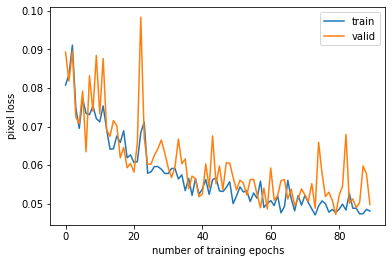

In [19]:
import matplotlib.pyplot as plt

plt.plot(loss_curve_train, label='train')
plt.plot(loss_curve_valid, label='valid')
plt.legend()
plt.xlabel('number of training epochs')
plt.ylabel('pixel loss')

# Results

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Text(0.5, 1.0, 'Predicted image')

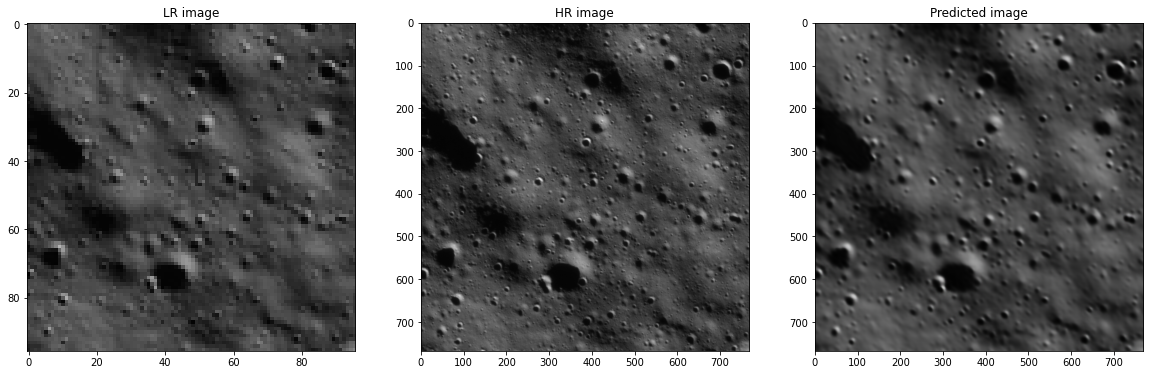

In [20]:
crop_size = 8*96  # crop size of target HR images
scaling_factor = 8
train_dataset = SRDataset(data_folder,
                          split='train',
                          crop_size=crop_size,
                          scaling_factor=scaling_factor,
                          lr_img_type='[-1, 1]',
                          hr_img_type='[-1, 1]')
img_lr, img_hr = train_dataset[25]
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow((img_lr.swapaxes(0,1).swapaxes(1,2) + 1) * 0.5)
plt.title('LR image')
plt.subplot(132)
plt.imshow((img_hr.swapaxes(0,1).swapaxes(1,2) + 1) * 0.5)
plt.title('HR image')

checkpoint = torch.load('./checkpoint_srresnet.pth.tar')
model = checkpoint['model']
imr_pred = model(torch.tensor(img_lr).unsqueeze(0).to(device))

plt.subplot(133)
plt.imshow((imr_pred.detach().cpu().squeeze().numpy().swapaxes(0,1).swapaxes(1,2) + 1) * 0.5)
plt.title('Predicted image')

# Apply the results to some image

In [21]:
img = imread('https://www.popsci.com/uploads/2019/01/07/GMY7X5OKPSBGSTSFEZXDEYW6JU-1024x1024.jpg').astype(float) / 255

(-0.5, 1023.5, 1023.5, -0.5)

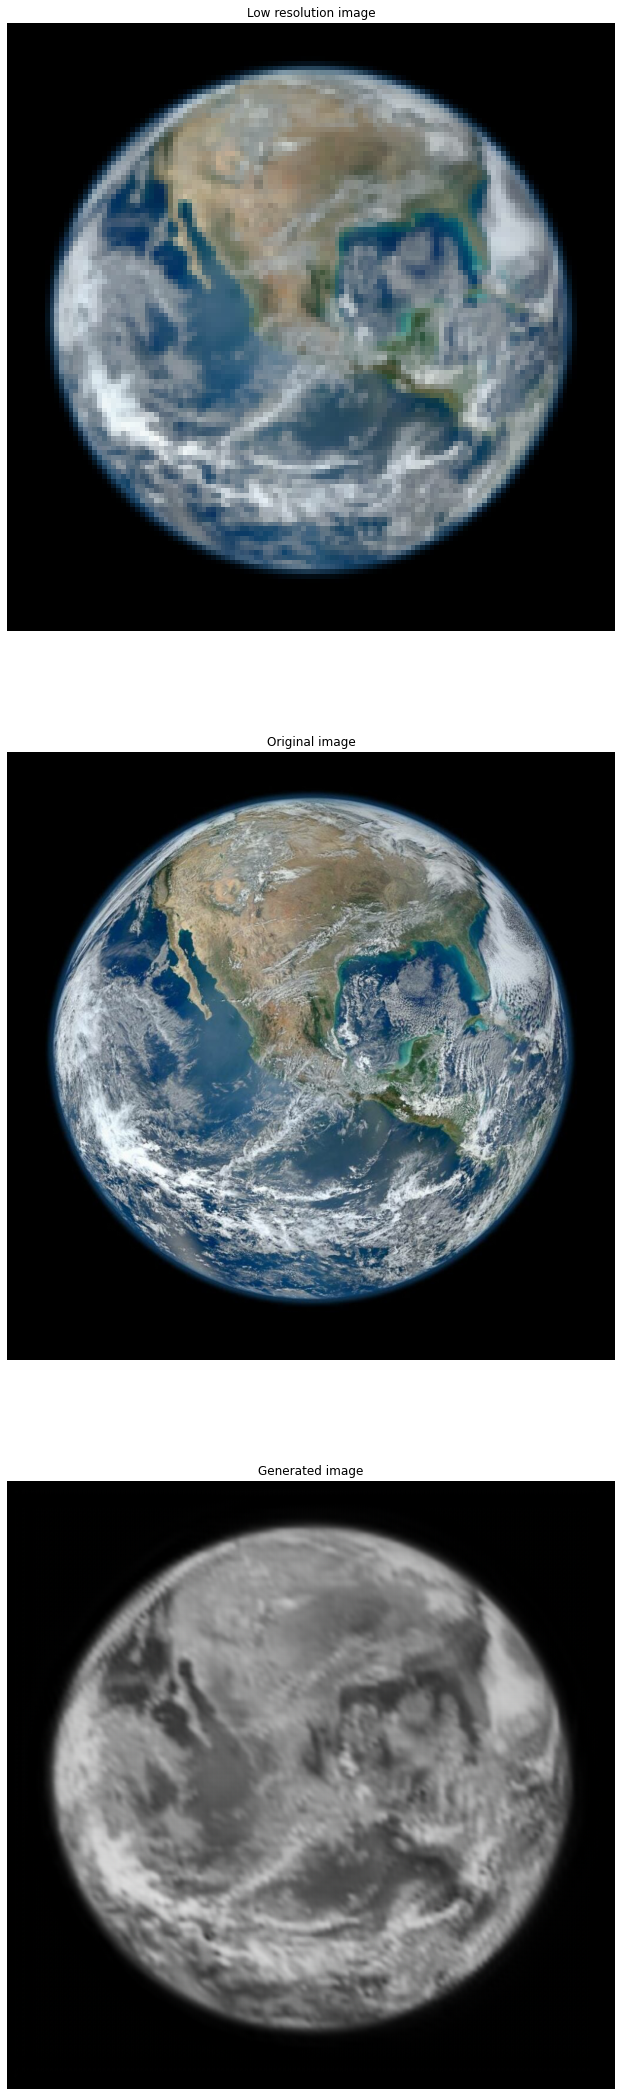

In [22]:

img_lr = resize(img,(int(img.shape[0]/8), int(img.shape[1]/8)))
plt.figure(figsize=(15,38))
plt.subplot(311)
plt.imshow(img_lr)
plt.title('Low resolution image')
plt.axis('off')

plt.subplot(312)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')

checkpoint = torch.load('./checkpoint_srresnet.pth.tar')
model = checkpoint['model']
imr_pred = model(torch.tensor(img_lr).swapaxes(1,2).swapaxes(0,1).unsqueeze(0).to(device).float())

plt.subplot(313)
plt.imshow(imr_pred.detach().cpu().squeeze().numpy().swapaxes(0,1).swapaxes(1,2))
plt.title('Generated image')
plt.axis('off')

# plt.savefig('earth.png', dpi=300, bbox_inches='tight')

(-0.5, 1023.5, 1023.5, -0.5)

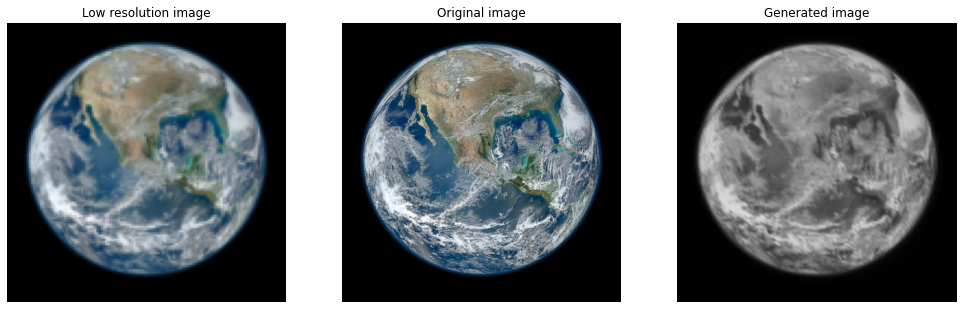

In [23]:
img_lr = resize(img,(int(img.shape[0]/8), int(img.shape[1]/8)))
plt.figure(figsize=(17,10))
plt.subplot(131)
plt.imshow(img_lr)
plt.title('Low resolution image')
plt.axis('off')

plt.subplot(132)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')

checkpoint = torch.load('./checkpoint_srresnet.pth.tar')
model = checkpoint['model']
imr_pred = model(torch.tensor(img_lr).swapaxes(1,2).swapaxes(0,1).unsqueeze(0).to(device).float())

plt.subplot(133)
plt.imshow(imr_pred.detach().cpu().squeeze().numpy().swapaxes(0,1).swapaxes(1,2))
plt.title('Generated image')
plt.axis('off')